# Regularization

##### Keywords: regularization, linear regression, cross-validation, ridge, lasso, complexity parameter

## Contents
{:.no_toc}
*  
{: toc}

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## Revisiting the model

Let $x$ be the fraction of religious people in a county and $y$ be the probability of voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.

In [4]:
dffull=pd.read_csv("data/religion.csv")
dffull.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


In [5]:
x=dffull.rfrac.values
f=dffull.promney.values

In [6]:
df = pd.read_csv("data/noisysample.csv")
df.head()

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


In [7]:
from sklearn.cross_validation import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [9]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

In [10]:
degrees=range(21)
traintestlists=make_features(xtrain, xtest, degrees)

## Constraining parameters by penalty

Upto now we have focussed on finding the polynomial with the right degree of complexity $d^*$ given the data that we have.

Let us now ask a different question: if we are going to fit the data with an expressive model such as 20th order polynomials, how can we **regularize** or smooth or restrict the choices of the kinds of 20th order polynomials that we allow in our fits. In other words, we are again trying to bring down the complexity of the hypothesis space, but by a different tack: a tack which prefers smooth polynomials over wiggly ones.

That is, if we want to fit with a 20th order polynomial, ok, lets fit with it, but lets reduce the size of, or limit the functions in $\cal{H}_{20}$ that we allow.

In a sense we have already done this, havent we? When we compared $\cal{H_{1}}$ over $\cal{H_{20}}$, we imposed a **hard constraint** by setting all polynomial co-efficients for terms higher than $x$ to 0. In other words you can think of a line as a 20th degree polynomial with many 0 coefficients. Why not have the math machinery do this for you than do it by hand, and use the data to figure out how to make the cut. 

We do this by a **soft constraint** by setting:

$$\sum_{i=0}^j a_i^2 < C.$$

This setting is called the Ridge.

This ensures that the coefficients dont get too high, which makes sure we dont get wildly behaving pilynomials with high coefficients. If we set 

$$\sum_{i=0}^j | a_i | < C,$$

it can be shown that some coefficients will be set to exactly 0. This is called the Lasso.

It turns out that we can do this by adding a term to the empirical risk that we minimize on the training data for $\cal{H}_j$ (seeing why is beyond the scope here but google on lagrange multipliers and the dual problem):

$$\cal{R}(h_j) =  \sum_{y_i \in \cal{D}} (y_i - h_j(x_i))^2 +\alpha \sum_{i=0}^j a_i^2.$$

This new risk takes the empirical risk and adds a "penalty term" to it to minimize overfitting. The term is proportional to the sum of the squares of the coefficients and is positive, so it will keep their values down

 The entire structure is similar to what we did to find the optimal $d=*$, with $\alpha$ being the analog of $d$. And thus we can use the same validation and cross-validation technology that we developed to estimate $d$.

This technique is called **regularization** or **shrinkage** as it takes the coefficients $a_i$ towards smaller sizes. As you have seen earlier, for polynomials this corresponds to choosing smooth functions over wiggly functions. When $\alpha=0$ we have the regular polynomial regression problem, and if we are using 20th order polynomials we will wildly overfit. We are in the high variance zone. The problem with a non-zero $\alpha$ is called **ridge regression**. As $\alpha$ increases, the importance of the penalty term increases at the expense of the ERM term, and we are pushed to increase the smoothness of the polynomials. When $\alpha$ becomes very large the penalty term dominates and we get into the high bias zone. Thus $\alpha$ acts as a complexity parameter just like $d$ did, with high complexity being $\alpha \to 0$.

### A toy example

Even though we are not doing any proofs, let us illustrate the concept of regularization using a line fit to a sine wave. We fit a straight line to 3 points, choosing 100 such sets of 3 points from the data set.

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(100, 3)


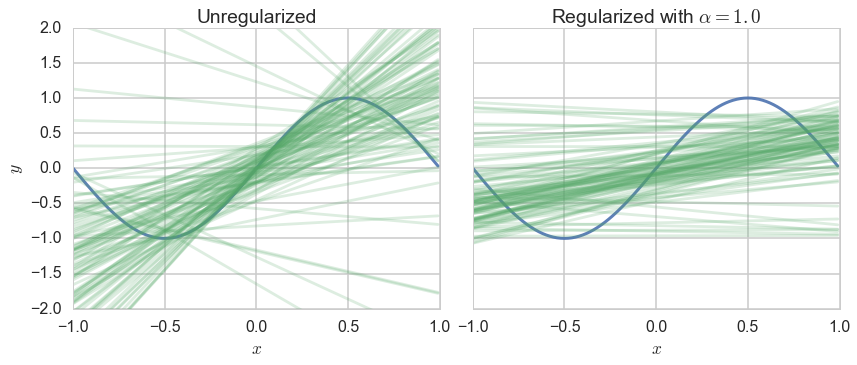

In [11]:
xs=np.arange(-1.,1.,0.01)
ff = lambda x: np.sin(np.pi*x)
ffxs=ff(xs)
axes=make_simple_plot()
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
axes[0].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
axes[1].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
from sklearn.linear_model import Ridge
D=np.empty((100,3), dtype="int")
print(D.shape)
for i in range(100):
    D[i,:] = np.random.choice(200, replace=False, size=3)
for i in range(100):
    choices = D[i,:]
    #regular fit
    p1=np.polyfit(xs[choices], ffxs[choices],1)
    #ridge fit
    est = Ridge(alpha=1.0)
    est.fit(xs[choices].reshape(-1,1), ffxs[choices])
    axes[0].plot(xs, np.polyval(p1, xs), color=c1, alpha=0.2)
    axes[1].plot(xs, est.predict(xs.reshape(-1,1)), color=c1, alpha=0.2)
axes[0].set_title("Unregularized");
axes[1].set_title("Regularized with $\\alpha=1.0$");

In the left panel we plot unregularized straight line fits. The plot is hairy, since choosing 3 points from 200 between -1 and 1 dosent constrain the lines much at all. On the right panel, we plot the output of **Ridge** regression with $\alpha=1$. This corresponds to adding a term to the empirical risk of $\alpha\, (a_0^2 + a_1^2)$ where $a_0$ and $a_1$ are the intercept and slope of the line respectively. Notice that the lines are much more constrained  in this second plot. The penalty term has regularized the values of the intercept and slope, and forced the intercept to be closer to 0 and the lines to be flatter.

### Contrast with complexity parameter validation

Notice that in regularization, we are adding a term to the **training error**, once $\alpha$ is defined. It is this term that is estimated..

When we were fitting for the degree of the polynomial, there was no explicit added term, we just fit the regular model. But there, as with regularization, the choice of the hyperparameter was made by comparing validation risks which were calculated by taking the parameters found with fixed hyperparameters on the training set.

## Regularization of the Romney model with Cross-Validation

In [12]:
def plot_functions(est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", alpha=0.4)
    ax.plot(xtest, ytest, 's', label="testing", alpha=0.6)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX),  '.', label="alpha = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')
    
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')

Lets now go back to the Romney voting model and see what regularization does to the fits in that model. The addition of a penalty term to the risk or error causes us to choose a smaller subset of the entire set of complex $\cal{H_{20}}$ polynomials. This is shown in the diagram below where the balance between bias and variance occurs at some subset $S_{\*}$ of the set of 20th order polynomials indexed by $\alpha_{\*}$ (there is an error on the diagram, the 13 there should actually be a 20).

![m:caption](images/complexity-error-reg.png)

Lets see what some of the $\alpha$s do. The diagram below trains on the entire training set, for given values of $\alpha$, minimizing the penalty-term-added training error.

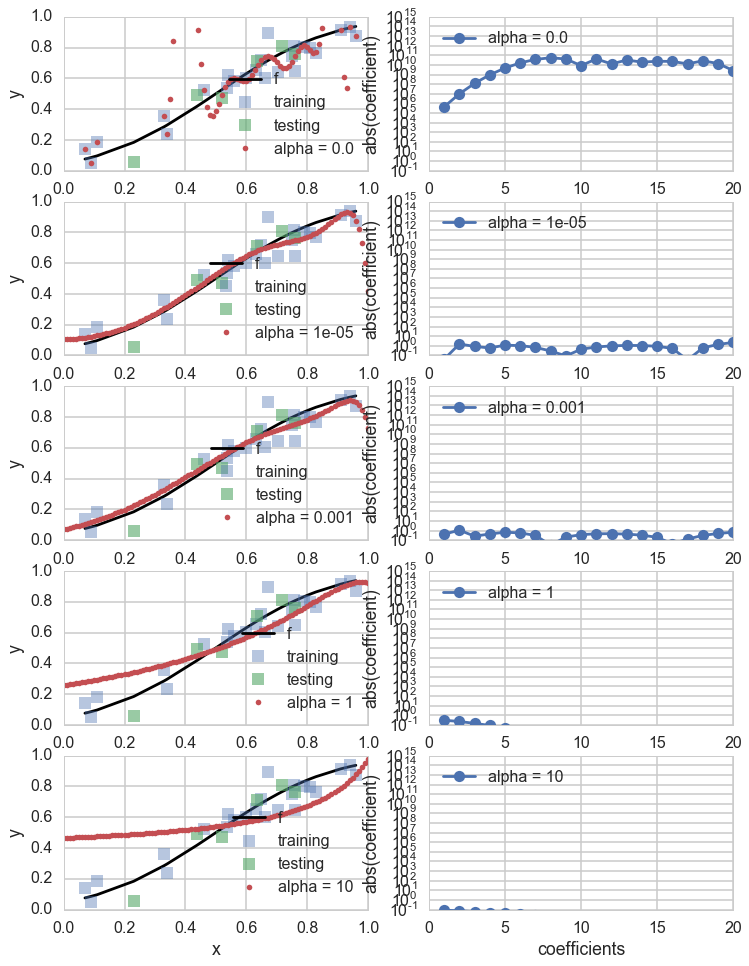

In [13]:
fig, rows = plt.subplots(5, 2, figsize=(12, 16))
d=20
alphas = [0.0, 1e-5, 1e-3, 1, 10]
Xtrain = traintestlists[d]['train']
Xtest = traintestlists[d]['test']
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

As you can see, as we increase $\alpha$ from 0 to 1, we start out overfitting, then doing well, and then, our fits, develop a mind of their own irrespective of data, as the penalty term dominates the risk.

Lets use cross-validation to figure what this critical $\alpha_*$ is. To do this we use the concept of a *meta-estimator* from scikit-learn. As the API paper puts it:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(clf, param_grid=parameters, cv=4, scoring="mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over thefolds using `KFolds` and the averaging we did previously, doint it all for us. It takes a parameter grid in the shape of a dictionary as input, and sets $\alpha$ to the appropriate parameter values one by one. It then trains the model, cross-validation fashion, and gets the error. Finally it compares the errors for the different $\alpha$'s, and picks the best choice model.

In [15]:
from sklearn.metrics import make_scorer
#, 1e-6, 1e-5, 1e-3, 1.0
from sklearn.grid_search import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

In [16]:
fitmodel = cv_optimize_ridge(Xtrain, ytrain, n_folds=4)

In [17]:
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 {'alpha': 0.0005},
 -0.005863476137886476,
 [mean: -0.01156, std: 0.00816, params: {'alpha': 1e-08},
  mean: -0.00643, std: 0.00350, params: {'alpha': 1e-06},
  mean: -0.00618, std: 0.00355, params: {'alpha': 1e-05},
  mean: -0.00596, std: 0.00358, params: {'alpha': 5e-05},
  mean: -0.00589, std: 0.00369, params: {'alpha': 0.0001},
  mean: -0.00586, std: 0.00424, params: {'alpha': 0.0005},
  mean: -0.00592, std: 0.00446, params: {'alpha': 0.001},
  mean: -0.00587, std: 0.00458, params: {'alpha': 0.01},
  mean: -0.00606, std: 0.00406, params: {'alpha': 0.1},
  mean: -0.01280, std: 0.00548, params: {'alpha': 1.0}])

Our best model occurs for $\alpha=0.01$. We also output the mean cross-validation error at different $\alpha$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

We refit the estimator on old training set, and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.

In [18]:
alphawechoose = fitmodel.best_params_['alpha']
clf = Ridge(alpha=alphawechoose).fit(Xtrain,ytrain)

In [19]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

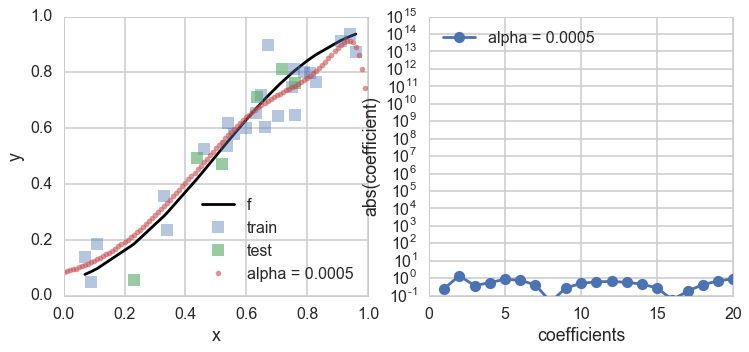

In [20]:
fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r=rows
plot_functions_onall(clf, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(clf, r, alphawechoose)

As we can see, the best fit model is now chosen from the entire set of 20th order polynomials, and a non-zero hyperparameter $\alpha$ that we fit for ensures that only smooth models amonst these polynomials are chosen, by setting most of the polynomial coefficients to something close to 0 (Lasso sets them exactly to 0).